# Assignment 5 #

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized. The distances between nodes are calculated as Euclidean distances rounded mathematically to integer values. The distance matrix should be calculated just after reading an instance and then only the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow instances defined only by distance matrices. 

## Read the data ##

In [1]:
import pandas as pd
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from math import sqrt
from typing import List, Optional, Tuple, Union 

In [2]:
# read data into dataframes
instances = {
    "A": pd.read_csv("data/TSPA.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "B": pd.read_csv("data/TSPB.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "C": pd.read_csv("data/TSPC.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "D": pd.read_csv("data/TSPD.csv", sep=';', header=None, names=["x", "y", "cost"]),
}

In [3]:
def calculate_distance_matrix(df: pd.DataFrame) -> NDArray[np.int32]:
    """
    Calculate the distance matrix from the dataframe.
    The dataframe contains 'x' and 'y' columns for the coordinates.
    The distances are Euclidean, rounded to the nearest integer + the cost of the destination node.
    """
    coordinates = df[['x', 'y']].to_numpy()
    dist_matrix = np.zeros(shape=(len(df), len(df)))
    for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            dist_matrix[i, j] = round(sqrt((coordinates[i, 0] - coordinates[j, 0])**2 + (coordinates[i, 1] - coordinates[j, 1])**2))
    return dist_matrix

In [4]:
distances_matrices = {
    "A": calculate_distance_matrix(instances["A"]),
    "B": calculate_distance_matrix(instances["B"]),
    "C": calculate_distance_matrix(instances["C"]),
    "D": calculate_distance_matrix(instances["D"])
}

costs = {
    "A": instances["A"]["cost"].to_numpy(),
    "B": instances["B"]["cost"].to_numpy(),
    "C": instances["C"]["cost"].to_numpy(),
    "D": instances["D"]["cost"].to_numpy()
}

In [5]:
def visualize_selected_route(
    selected_nodes_indices: ArrayLike, 
    dataframe: pd.DataFrame,
    title: str) -> None:
    """
    Visualize the selected route returned by the algorithm, including the cost of each node represented by a colormap.

    Parameters:
    selected_nodes_indices (list): Indices of the selected nodes in the route.
    dataframe (DataFrame): DataFrame containing 'x', 'y', and 'cost' columns for each node.
    """
    x = dataframe["x"].to_numpy()
    y = dataframe["y"].to_numpy()
    costs = dataframe["cost"].to_numpy()

    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(costs), vmax=max(costs))

    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(x, y, c=costs, cmap=cmap, norm=norm, s=100)
    plt.colorbar(scatter, label='Node Cost')

    for i, node in enumerate(selected_nodes_indices):
        start_node = selected_nodes_indices[i]
        end_node = selected_nodes_indices[(i + 1) % len(selected_nodes_indices)]
        plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-', lw=1)

    plt.title(title, fontsize=18)
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.grid(True)
    plt.show()

C:\Users\janko\AppData\Local\Temp\ipykernel_9860\3272644663.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


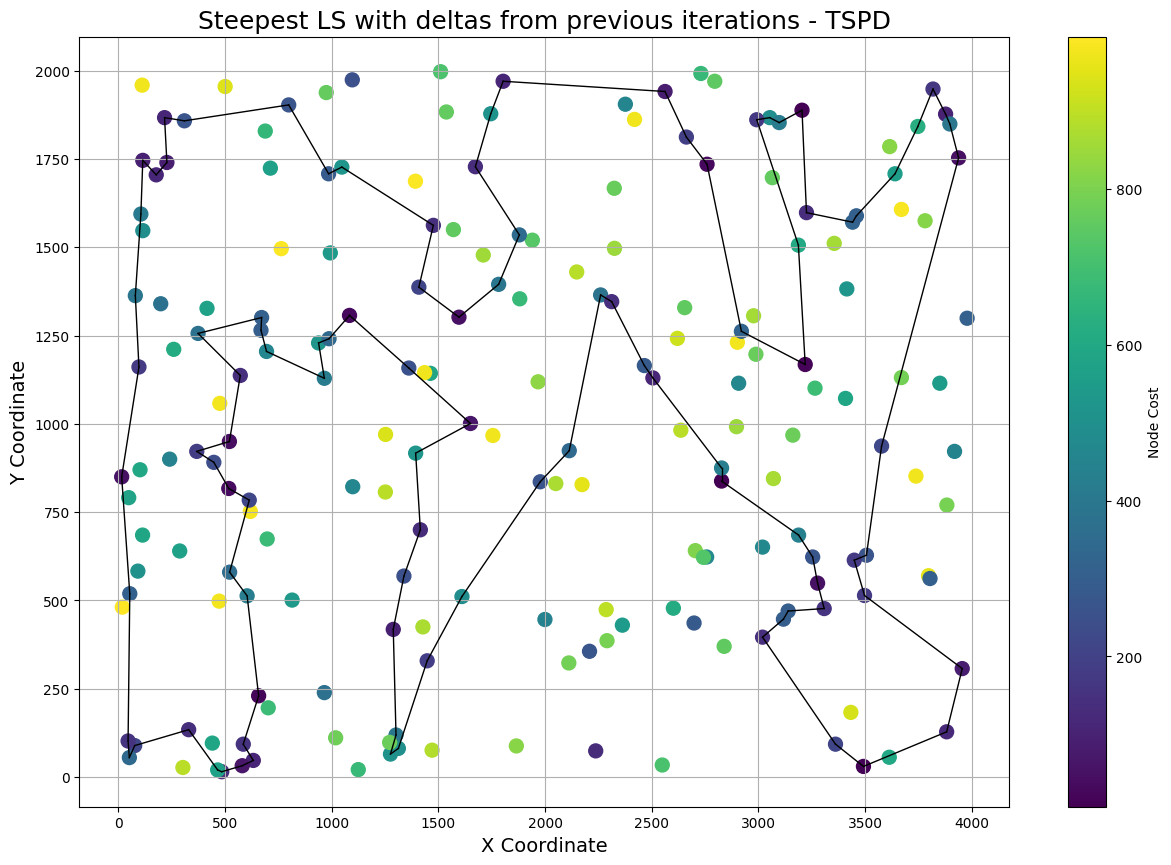

In [7]:
t = [
        69,
        32,
        113,
        115,
        40,
        172,
        95,
        19,
        190,
        198,
        135,
        169,
        66,
        92,
        122,
        143,
        179,
        197,
        183,
        34,
        31,
        101,
        38,
        103,
        121,
        127,
        24,
        50,
        154,
        134,
        25,
        36,
        194,
        123,
        165,
        37,
        137,
        88,
        55,
        4,
        153,
        146,
        99,
        57,
        80,
        157,
        145,
        136,
        61,
        73,
        33,
        29,
        18,
        132,
        185,
        47,
        189,
        181,
        147,
        159,
        64,
        129,
        89,
        58,
        72,
        114,
        67,
        156,
        91,
        70,
        51,
        174,
        188,
        140,
        148,
        141,
        130,
        142,
        21,
        192,
        196,
        117,
        150,
        162,
        44,
        71,
        166,
        59,
        119,
        193,
        139,
        97,
        107,
        12,
        52,
        16,
        14,
        8,
        63,
        82
    ]
visualize_selected_route(t, instances["D"], "Steepest LS with deltas from previous iterations - TSPD")

In [6]:
def objective_function(solution: list[int], dist_matrix: list[list[int]], costs: list[int]) -> int:
    total_score = 0
    n = len(solution)
    for x in range(n):
        total_score += dist_matrix[solution[x - 1]][solution[x]]
        total_score += costs[solution[x]]
    return total_score

In [7]:
# A function that generates a random solution
def generate_random_solution(n: int) -> list[int]:
    """
    Generate a random solution for a given number of nodes.

    :param n: The number of nodes.
    :return: A list of nodes representing the solution.
    """
    return random.sample(range(0, n * 2), n)

# Repository for Local Search solution finder #

In [8]:
from abc import ABC, abstractmethod
from typing import Union, Optional


class LocalSearch(ABC):
    """
    Abstract class for local search algorithms.
    """
    def __init__(self, 
                 initial_solution: list[int], 
                 distance_matrix: list[list[int]], 
                 costs: list[int]) -> None:
        """
        :param initial_solution: The initial solution.
        :param initial_score: The score of the initial solution.
        :param distance_matrix: 2D list representing the distances between nodes.
        """
        self.initial_solution = initial_solution
        self.initial_score = objective_function(initial_solution, distance_matrix, costs)
        self.distance_matrix = distance_matrix
        self.costs = costs
        
        self.all_nodes = list(range(100*2))
        self.unselected_nodes = [node for node in self.all_nodes if node not in self.initial_solution]
        
        self.current_solution: list[int] = initial_solution
        self.current_score = self.initial_score
        
        self.moves = {
            "intra-two-edges-exchange": self.two_edges_exchange,
            "intra-two-nodes-exchange": self.two_nodes_exchange,
            "inter-route-exchange": self.inter_route_exchange
        }
        
        self.moves_utils = {
            "intra-two-edges-exchange": self.get_utils_intra_two_edges_exchange,
            "intra-two-nodes-exchange": self.get_utils_intra_two_nodes_exchange,
            "inter-route-exchange": self.get_utils_inter_route_exchange
        }
        
        
    @abstractmethod
    def get_utils_intra_two_edges_exchange(self):
        raise NotImplementedError
    
    @abstractmethod
    def get_utils_intra_two_nodes_exchange(self):
        raise NotImplementedError
    
    @abstractmethod
    def get_utils_inter_route_exchange(self):
        raise NotImplementedError

    # two method for intra moves
    @abstractmethod
    def two_edges_exchange(self, start_index: int = 0, direction: str = "right") -> Union[tuple[list[int], int], None]:
        """This method should return a new solution and its score if a better solution is found, otherwise None.
        For a greedy algorithm, the first better solution found should be returned. For a steepest local search,
        the best solution among all possible solutions should be returned, if there is no better solution, just
        return None. For a steepest local search, both neighborhood moves will return one solution, then we will
        take the better one among these two solutions.

        Parameters
        ----------
        current_solution : list[int]
        current_distance : int
        distance_matrix : list[list[int]]

        Returns
        -------
        tuple[list[int], int] | None
            A single better solution founded by the algorithm, or None if no better solution is found.
        """
        raise NotImplementedError
    
    @abstractmethod
    def two_nodes_exchange(self, start_index=0, direction='right') -> Union[tuple[list[int], int] , None]:
        raise NotImplementedError
    
    # one method for inter move
    @abstractmethod
    def inter_route_exchange(self, start_index=0, direction="right") -> Union[tuple[list[int], int] , None]:
        raise NotImplementedError
    
    @abstractmethod
    def run(self, *args, **kwargs) -> None:
        """
        Run the algorithm.
        """
        pass

In [9]:
def check_overlap(list1, list2):
    # Use set intersection to find common elements
    common_elements = set(list1) & set(list2)
    if common_elements:
        raise ValueError(f"Error: The following elements are present in both lists: {common_elements}")
    
def check_for_duplicates(lst, name: str):
    if len(lst) != len(set(lst)):
        raise ValueError(f"Duplicates found in the {name}. {lst}")

# Steepest Local Search with deltas from previous iterations #

In [10]:
class SteepestLocalSearch(LocalSearch):
    def __init__(self, 
                 initial_solution: list[int], 
                 distance_matrix: list[list[int]], 
                 costs: list[int]) -> None:
        super().__init__(initial_solution, distance_matrix, costs)
        
    def get_utils_intra_two_nodes_exchange(self):
        n = len(self.current_solution)
        num_solutions = n*(n-1)/2
        start_index = random.randint(0, num_solutions-1)
        if start_index < num_solutions/2:
            direction = 'right' 
        else:   
            direction = 'left'
        return start_index, direction
    
    def get_utils_intra_two_edges_exchange(self):
        n = len(self.current_solution)
        num_solutions = n*(n-3)/2
        start_index = random.randint(0, int((num_solutions-1)/2))
        direction = random.choice(['right', 'left'])
        return start_index, direction
    
    def get_utils_inter_route_exchange(self):
        n_selected = len(self.current_solution)
        n_unselected = len(self.unselected_nodes)
        num_solutions = n_selected*n_unselected
        start_index = random.randint(0, int((num_solutions-1)/2))
        direction = random.choice(['right', 'left'])
        return start_index, direction
        
    def two_edges_exchange(self,
                            start_index: int = 0,
                            direction: str = "right"):
        """
        Generate a new solution by exchanging two edges in the current solution,
        starting from a given index and moving in the specified direction.

        :param current_solution: List of nodes in the current solution.
        :param current_distance: The score of the current solution.
        :param distance_matrix: 2D list representing the distances between nodes.
        :param start_index: The index from which to start searching for a better solution.
        :param direction: The direction in which to search for a better solution ("right" or "left").
        :return: A tuple containing the new solution and its score if it's better,
                otherwise the original solution and score.
        """
        n = len(self.current_solution)

        if direction == "right":
            range_i = range(n - 2)
            range_j = lambda i: range(i + 2, n)
        else:  # direction == "left"
            range_i = range(n - 3, -1, -1)
            range_j = lambda i: range(n - 1, i + 1, -1)
        count = 0
        method_best_score = float("inf")
        method_best_solution = None
        for i in range_i:
            for j in range_j(i):
                if count >= start_index:
                    new_solution = (self.current_solution[:i + 1] 
                                    + self.current_solution[i + 1:j + 1][::-1] 
                                    + self.current_solution[j + 1:])

                    score_delta = (
                        -self.distance_matrix[self.current_solution[i]][self.current_solution[i + 1]]
                        -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                        +self.distance_matrix[self.current_solution[i]][self.current_solution[j]]
                        +self.distance_matrix[self.current_solution[i + 1]][self.current_solution[(j + 1) % n]]
                    )
                    new_score = self.current_score + score_delta

                    if new_score < method_best_score:
                        method_best_score = new_score
                        method_best_solution = new_solution

                count += 1  # Increment the counter after checking the condition
        return method_best_solution, method_best_score, "two-edges-exchange"
    
    def two_nodes_exchange(self, start_index=0, direction='right'):
        n = len(self.current_solution)
        total_moves = n * (n - 1) // 2  # Total number of possible swaps

        index_pairs = [(x, y) for x in range(n) for y in range(x+1, n)]
        # Adjust the indices list based on the direction
        if direction == 'left':
            index_pairs = index_pairs[::-1]
            start_index = total_moves - start_index - 1 
        method_best_score = float("inf")
        method_best_solution = None
        for count, (i, j) in enumerate(index_pairs[start_index:], start=start_index):
            temp = self.current_solution[:]
            temp_score = self.current_score

            if i == 0 and j == n - 1:  # special case: first and last nodes
                score_delta = (
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[0]]
                    -self.distance_matrix[self.current_solution[j-1]][self.current_solution[j]]
                    -self.distance_matrix[self.current_solution[0]][self.current_solution[1]]
                    +self.distance_matrix[self.current_solution[j]][self.current_solution[1]]
                    +self.distance_matrix[self.current_solution[j-1]][self.current_solution[0]]
                    +self.distance_matrix[self.current_solution[0]][self.current_solution[j]]
                )
            elif j == i + 1:  # adjacent nodes case
                score_delta = (
                    -self.distance_matrix[self.current_solution[i - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[i - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[i]][self.current_solution[(j + 1) % n]]
                )
            else:  # non-adjacent nodes case
                score_delta = (
                    -self.distance_matrix[self.current_solution[i - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[j - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[i - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[j - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[i]][self.current_solution[(i + 1) % n]]
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[i]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[j]][self.current_solution[(i + 1) % n]]
                )

            temp[i], temp[j] = temp[j], temp[i]
            temp_score += score_delta
            # If the new score is better, return the new solution immediately
            if temp_score < method_best_score:
                method_best_score = temp_score
                method_best_solution = temp
        return method_best_solution, method_best_score, "two-nodes-exchange"
    
    
    def inter_route_exchange(self, start_index=0, direction="right"):
        n_selected = len(self.current_solution)
        n_unselected = len(self.unselected_nodes)
        
        # Create all possible combinations of selected and unselected nodes
        all_combinations = [(i, j) for i in range(n_selected) for j in range(n_unselected)]
        if direction == "left":
            all_combinations = all_combinations[::-1]
        all_scores = []
        method_best_score = float("inf")
        method_best_solution = None
        method_best_new_node = None
        method_best_old_node = None
        for i, j in all_combinations[start_index:]:
            selected_node = self.current_solution[i]
            new_node = self.unselected_nodes[j]
            new_solution = self.current_solution.copy()
            new_solution[i] = new_node
            prev_node_index = (i - 1) % n_selected
            next_node_index = (i + 1) % n_selected
            score_delta = (
                -self.distance_matrix[self.current_solution[prev_node_index]][selected_node]
                -self.distance_matrix[selected_node][self.current_solution[next_node_index]]
                +self.distance_matrix[self.current_solution[prev_node_index]][new_node]
                +self.distance_matrix[new_node][self.current_solution[next_node_index]]
                -self.costs[selected_node]
                +self.costs[new_node]
            )
            new_score = self.current_score + score_delta
            all_scores.append(new_score)
            if new_score < method_best_score:
                method_best_score = new_score
                method_best_solution = new_solution
                method_best_new_node = new_node
                method_best_old_node = selected_node
        
        return method_best_solution, method_best_score, "inter-route-exchange", method_best_new_node, method_best_old_node
    
    def run(self, 
            start_solution: Optional[List[int]],
            moves: list[str],
            show_progress: bool = True) -> tuple[list[int], int]:
        if not set(moves).issubset(self.moves.keys()):
            raise ValueError("Invalid moves list")
        if len(moves) != 2:
            raise ValueError("Only two moves are supported")
        
        if start_solution is not None:
            self.current_solution = start_solution
            
            self.current_score = objective_function(start_solution, self.distance_matrix, self.costs)    
            
        progress = True
        epoch_counter = 0
        
        while progress:
            best_move_solutions = []
            improvement = 0
            for move in moves:
                if move == "inter-route-exchange":
                    new_solution, new_score, method,new_node, old_node = self.moves[move]()
                    best_move_solutions.append((new_solution, new_score, method, new_node, old_node))
                else:
                    new_solution, new_score, method = self.moves[move]()        
                    best_move_solutions.append((new_solution, new_score, method))
            
            best_solution = min(best_move_solutions, key=lambda x: x[1])
            if best_solution[1] < self.current_score:
                improvement = 1
                if best_solution[2] == "inter-route-exchange":
                    # dopiero tutaj zmieniamy unselected, jeśli rozwiązanie z tej metody zostało
                    # faktycznie zaakceptowane.
                    self.unselected_nodes.remove(best_solution[3])
                    self.unselected_nodes.append(best_solution[4])
                    
                self.current_solution = best_solution[0]
                self.current_score = best_solution[1]
                
            # sprawdzanie czy nie ma błędów
            check_overlap(self.current_solution, self.unselected_nodes)
            check_for_duplicates(self.current_solution, "solution")
            check_for_duplicates(self.unselected_nodes, "unselected")
            if len(self.unselected_nodes) != 100:
                raise ValueError(f"unselected contains {len(self.unselected_nodes)} elements instead of 100")
            if improvement == 0:
                progress = False
                return self.current_solution, self.current_score, epoch_counter
                
            epoch_counter += 1
            if epoch_counter % 50 == 0 and show_progress:
                print(f"Epoch: {epoch_counter}, Score: {self.current_score}")
        
        
            

In [25]:
import time


lm = {i: "1" for i in range(90000,100000)}


# exploring the whole neighborhood
start = time.time()
for i in range(100000):
    if i not in lm:
        # fake operation
        b = i * 5 * 4 * 13 / 4 * 8
end = time.time()
print(end - start)

# exploring only not cached
start = time.time()
for i in range(90000):
    b = i * 5 * 4 * 13 / 4 * 8
end = time.time()
print(end - start)


0.11913418769836426
0.10096502304077148


In [72]:
from dataclasses import dataclass
from enum import Enum


@dataclass(frozen=True)
class Node:
    index: int
    cost: int


@dataclass(frozen=True)
class Edge:
    """Edge representation. src is a source node,
    dst is a destination node.
    """
    src: Node
    dst: Node


@dataclass(frozen=True)
class Solution:
    nodes: list[Node]
    
    @property
    def edges(self) -> list[Edge]:
        if not self.nodes:
            return []
        return [Edge(self.nodes[i], self.nodes[(i + 1) % len(self.nodes)]) for i in range(len(self.nodes))]


@dataclass(frozen=True)
class RemovedEdges:
    edges: tuple[Edge]

    def __eq__(self, other):
        if isinstance(other, RemovedEdges):
            return frozenset(self.edges) == frozenset(other.edges)
        return False

    def __hash__(self):
        return hash(frozenset(self.edges))


@dataclass(frozen=True)
class AddedEdges:
    edges: tuple[Edge]

    def __eq__(self, other):
        if isinstance(other, AddedEdges):
            return frozenset(self.edges) == frozenset(other.edges)
        return False

    def __hash__(self):
        return hash(frozenset(self.edges))
    

class MoveType(Enum):
    inter_route_exchange = "inter-route-exchange"
    intra_two_edges_exchange = "intra-two-edges-exchange"
    intra_two_nodes_exchange = "intra-two-nodes-exchange"


@dataclass(frozen=True)
class Move:
    removed_edges: RemovedEdges
    added_edges: AddedEdges
    type: MoveType

    def __eq__(self, other):
        if isinstance(other, Move):
            return (self.removed_edges == other.removed_edges and 
                    self.added_edges == other.added_edges and
                    self.type == other.type)
        return False

    def __hash__(self):
        return hash((self.removed_edges, self.added_edges, self.type))


# Test
removed = RemovedEdges((Edge(Node(0, 50), Node(1, 50)), Edge(Node(3, 50), Node(4, 50))))
added = AddedEdges((Edge(Node(0, 50), Node(1, 50)), Edge(Node(3, 50), Node(4, 50))))
move = Move(removed, added, "inter-route-exchange")

removed2 = RemovedEdges((Edge(Node(3, 50), Node(4, 50)), Edge(Node(0, 50), Node(1, 50))))
added2 = AddedEdges((Edge(Node(0, 50), Node(1, 50)), Edge(Node(3, 50), Node(4, 50))))
move2 = Move(removed2, added2, "inter-route-exchange")

a = {
    move: "1"
}

if move2 in a:
    print("yes")  # This should print "yes"

yes


In [68]:
@dataclass(frozen=True)
class Node:
    index: int
    cost: int


@dataclass(frozen=True)
class Edge:
    """Edge representation. src is a source node,
    dst is a destination node.
    """
    src: Node
    dst: Node


@dataclass(frozen=True)
class Solution:
    nodes: list[Node]
    
    @property
    def edges(self) -> list[Edge]:
        if not self.nodes:
            return []
        return [Edge(self.nodes[i], self.nodes[(i + 1) % len(self.nodes)]) for i in range(len(self.nodes))]

node1 = Node(0, 50)
node2 = Node(1, 50)
node3 = Node(2, 50)
node4 = Node(3, 50)
node5 = Node(4, 50)

solution = Solution([node1, node2, node3, node4, node5])

# This will print the edges as described
for edge in solution.edges:
    print(f"Edge from Node {edge.src.index} to Node {edge.dst.index}")

Edge from Node 0 to Node 1
Edge from Node 1 to Node 2
Edge from Node 2 to Node 3
Edge from Node 3 to Node 4
Edge from Node 4 to Node 0


In [89]:
import heapq
class MoveTracker:
    def __init__(self):
        self.moves_heap = []
        self.moves_set = set()

    def add_move(self, move, score):
        """Add a move with the given score to the tracker."""
        if move not in self.moves_set:
            heapq.heappush(self.moves_heap, (score, move))
            self.moves_set.add(move)

    def move_exists(self, move):
        """Check if a move exists in the tracker."""
        return move in self.moves_set
            
    def get_next_move(self):
        """Get and remove the move with the lowest score."""
        while self.moves_heap:
            score, move = heapq.heappop(self.moves_heap)
            if move in self.moves_set:
                self.moves_set.remove(move)
                return move, score
        return None

In [91]:
heap = MoveTracker()

heap.add_move("a", 50)
heap.add_move("b", 40)
heap.add_move("c", 30)
heap.add_move("d", 60)
heap.add_move("e", 70)
heap.add_move("f", -20)

while heap.moves_heap:
    # move, score = heap.get_next_move()
    print(heap.get_next_move())

('f', -20)
('c', 30)
('b', 40)
('a', 50)
('d', 60)
('e', 70)


In [99]:
from enum import Enum
from dataclasses import dataclass


class MoveType(Enum):
    inter_route_exchange = "inter-route-exchange"
    intra_two_edges_exchange = "intra-two-edges-exchange"
    intra_two_nodes_exchange = "intra-two-nodes-exchange"

@dataclass
class Test:
    type_move: MoveType

In [103]:
a = Test(type_move="inter-route-exchange")
if a.type_move == MoveType.inter_route_exchange:
    print("yes")

In [112]:
def order_edges(edges):
    if not edges:
        return []

    # Start with the first edge and initialize the ordered list of edges
    ordered_edges = [edges.pop(0)]

    # Iterate until all edges are ordered
    while edges:
        last_dst = ordered_edges[-1].dst
        for i, edge in enumerate(edges):
            if edge.src == last_dst:
                ordered_edges.append(edges.pop(i))
                break

    return ordered_edges

In [116]:
def apply_move_to_solution(solution: Solution, move: Move) -> Solution:
    # Step 1: Convert Solution.edges to a list for manipulation
    modified_edges = list(solution.edges)

    # Step 2: Remove edges in move.removed_edges from the list
    for edge in move.removed_edges.edges:
        if edge in modified_edges:
            modified_edges.remove(edge)

    # Step 3: Add edges in move.added_edges to the list
    modified_edges.extend(move.added_edges.edges)
    ordered_edges = order_edges(modified_edges)
    # Step 5: Convert the ordered list of edges to a list of nodes
    nodes_in_order = [ordered_edges[0].src] + [edge.dst for edge in ordered_edges[:-1]]

    # Step 6: Create and return a new Solution object
    new_solution = Solution(nodes=nodes_in_order)
    return new_solution


node1 = Node(0, 50)
node2 = Node(1, 50)
node3 = Node(2, 50)
node4 = Node(3, 50)
node5 = Node(4, 50)
solution = Solution([node1, node2, node3, node4, node5])
print("OLD EDGES")
print(solution.edges)
removed = RemovedEdges((Edge(Node(0, 50), Node(1, 50)), Edge(Node(1, 50), Node(2, 50)),Edge(Node(2, 50), Node(3, 50)), Edge(Node(3, 50), Node(4, 50))))
added = AddedEdges((Edge(Node(0, 50), Node(3, 50)), Edge(Node(3, 50), Node(2, 50)),Edge(Node(2, 50), Node(1, 50)), Edge(Node(1, 50), Node(4, 50))))
move = Move(removed, added, "two-edges-exchange")

new_solution = apply_move_to_solution(solution, move)
new_solution

OLD EDGES
[Edge(src=Node(index=0, cost=50), dst=Node(index=1, cost=50)), Edge(src=Node(index=1, cost=50), dst=Node(index=2, cost=50)), Edge(src=Node(index=2, cost=50), dst=Node(index=3, cost=50)), Edge(src=Node(index=3, cost=50), dst=Node(index=4, cost=50)), Edge(src=Node(index=4, cost=50), dst=Node(index=0, cost=50))]
[Edge(src=Node(index=4, cost=50), dst=Node(index=0, cost=50)), Edge(src=Node(index=0, cost=50), dst=Node(index=3, cost=50)), Edge(src=Node(index=3, cost=50), dst=Node(index=2, cost=50)), Edge(src=Node(index=2, cost=50), dst=Node(index=1, cost=50)), Edge(src=Node(index=1, cost=50), dst=Node(index=4, cost=50))]


Solution(nodes=[Node(index=4, cost=50), Node(index=0, cost=50), Node(index=3, cost=50), Node(index=2, cost=50), Node(index=1, cost=50)])